# Environment

In [4]:
!pip install gym -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827622 sha256=013febe61ae891fa9073167c407b27498d1de47527c0c046c375231987fb0eaf
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [5]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import sys
import numpy as np
from tqdm import tqdm
env = gym.make('Taxi-v3',render_mode = "ansi")
state = env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




# Plotting functions


In [ ]:
# plotting the option choosing policy based on passenger destination and drop location
def plot_option_choosing_Q_values(Q,message):

  # max q action for each pas and drop combination
  q_max = np.argmax(Q,axis=2).reshape(5,4)


  # plotting the q table
  fig, ax = plt.subplots()
  fig = plt.figure(figsize = (10,10))
  im = ax.imshow(q_max)

  cbar = ax.figure.colorbar(im, ax = ax, shrink=1 )

  ax.set_xticks(np.arange(4))
  ax.set_yticks(np.arange(5))

  ax.set_xticklabels(['goto R','goto G', 'goto Y', 'goto B'])
  ax.set_yticklabels(['goto R','goto G', 'goto Y', 'goto B','taxi'])

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

  labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
  for i in range(5):
    for j in range(4):
      text = ax.text(j, i, labels[q_max[i, j]],
                       ha="center", va="center", color="w")

  ax.set_title(message)
  fig.tight_layout()
  plt.show()

In [ ]:
# plotting the taxi moving policy for each of the num_options
def plot_taxi_policy_Q_values(Q,option,message):

  fig, ax = plt.subplots()
  fig = plt.figure(figsize = (10,10))

  # max q action for the taxi at all positions (x,y) for each option
  q_max = np.argmax(Q[option],axis = 2).reshape(5,5)
  im = ax.imshow(q_max)

  cbar = ax.figure.colorbar(im, ax = ax, shrink=1 )

  ax.set_xticks(np.arange(5))
  ax.set_yticks(np.arange(5))

  ax.set_xticklabels([0,1,2,3,4])
  ax.set_yticklabels([0,1,2,3,4])

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

  labels = {0:'south',1:'north', 2:'east', 3:'west'}
  for i in range(5):
    for j in range(5):
      text = ax.text(j, i, labels[q_max[i, j]],
                       ha="center", va="center", color="w")

  ax.set_title(message)
  fig.tight_layout()
  plt.show()

# Action Policy

In [1]:
# e greedy action policy
def egreedy_policy(q_values,state,epsilon):
  # best action
  best_action = np.argmax(q_values[state])

  if q_values[state].any() and random.random() > epsilon:
    return best_action
  else:
    return random.randint(0,q_values.shape[-1]-1)

# Hyperparameters

In [17]:
# environment parameters
num_states =500
nrows = 5
ncols = 5
npassengers = 5
ndests = 4

# Add hyperparameters you might need here
num_options = 4
gamma = 0.9
alpha = 0.1

epsilon = 0.05

num_epsiodes = 5000
max_steps = 400

# Simple Q-learning policy

In [ ]:
# code for running a simple Q -learning policy
def run_experiment_ql(gamma,alpha,epsilon,num_epsiodes,max_steps=None,print_flag=True,plot_flag = True):
  Q = np.zeros((env.observation_space.n,env.action_space.n))
  rewards_Q = []
  steps_Q = []
  avg_rewards_Q = []
  for episode in range(num_epsiodes):
    state,_ = env.reset()
    step = 0
    done = False
    total_rewards = 0
    total_steps = 0
    for step in range(max_steps):
      action = egreedy_policy(Q, state,epsilon)
      next_state, reward, done,_,_ = env.step(action)

      total_rewards+=reward
      total_steps +=1

      # simple q learning update
      Q[state][action] = Q[state][action] +  alpha*(reward + gamma*np.max(Q[next_state]) - Q[state][action])

      if done:
        break
      state = next_state

    rewards_Q.append(total_rewards)
    steps_Q.append(total_steps)
    avg_rewards_Q.append(np.mean(rewards_Q[-10:]))
    if print_flag and episode%100 == 0:
      sys.stdout.write("episode: {}, reward: {}, average_reward: {},steps to goal {}\n".format(episode, np.round(total_rewards, decimals=2),np.mean(rewards_Q[-10:]),max_steps))
  sys.stdout.write("Experiment completed! Rewards recorded!\n")
  if plot_flag:
    plt.plot(rewards_Q)
    plt.plot(avg_rewards_Q)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(steps_Q)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Steps for taxi to complete the task')
    plt.show()
  return avg_rewards_Q,Q

# Defining Option Class

In [ ]:
class Option:
    def __init__(self,env,option,Q,epsilon):
      self.env = env
      self.option = option
      self.Q  = Q
      self.destinations = self.env.unwrapped.locs
      self.epsilon = epsilon

    def policy_selection(self,state):
      '''
      defining option policy. If u reach the destination - pas at destination then
      pickup if drop is at the destination then return drop otherwise follow
      e - greeedy w.r.t taxi moving policy for the corresponding option.
      '''
      x,y,pas,drop = self.env.decode(state)
      if (x,y) == self.destinations[self.option]:
        if pas == self.option:
          return 4
        elif drop == self.option:
          return 5
        else:
          return egreedy_policy(self.Q[self.option],(x,y),self.epsilon)
      else:
        return egreedy_policy(self.Q[self.option],(x,y),self.epsilon)


    def termination_condition(self, state):
      '''
      Terminate when  you reach the required destination.
      '''
      x,y,_,_ = self.env.decode(state)

      if (x,y) == self.destinations[self.option]:
        return True
      else:
        return False

    def step(self, state):
       return self.policy_selection(state), self.termination_condition(state)

# SMDP Q learning

In [2]:
# SMDP Q learning to execute an option
def execute_smdp_option(Option,terminated,done,Q_hat,q_values_smdp,epsilon,state,option):
  episode_rewards = 0
  ep_steps = 0
  reward_bar = 0
  prev = state
  _,_,ini_pas,ini_drop = env.decode(prev)
  options = [0,1,2,3]
  while not terminated and not done:

    # execute the chosen option
    opt_class = Option(env,option,Q_hat,epsilon)
    option_action,terminated = opt_class.step(state)
    next_state, reward, done,_,_ = env.step(option_action)

    # keep track of cummulative reward
    reward_bar = gamma*reward_bar + reward
    episode_rewards+=reward
    ep_steps+=1

    # current state and next state positions
    x,y,pas,drop = env.decode(state)
    next_x,next_y,next_pas,next_drop = env.decode(next_state)

    # Update the poliy for moving the taxi using simple Q-learning methods
    if option_action in options:
      if terminated:
        Q_hat[option][x,y,option_action] = Q_hat[option][x,y, option_action] + alpha*(20 + gamma*np.max(Q_hat[option][next_x,next_y, :]) - Q_hat[option][x,y, option_action])
      else:
        Q_hat[option][x,y,option_action] = Q_hat[option][x,y, option_action] + alpha*(reward + gamma*np.max(Q_hat[option][next_x,next_y, :]) - Q_hat[option][x,y, option_action])

    state = next_state

  # Update the option learning policy using the SMDP Q-learning update at the end of timesteps.
  q_values_smdp[ini_pas,ini_drop,option] += alpha*(reward_bar+(gamma**ep_steps)*np.max(q_values_smdp[next_pas,next_drop,:])-q_values_smdp[pas,drop,option])
  return Q_hat,q_values_smdp,epsilon,state,episode_rewards,ep_steps,done

In [ ]:

# running the SMDP Q- learning model.
def run_experiment_smdp(Option,gamma,alpha,epsilon,num_epsiodes,max_steps=None,print_flag=True,plot_flag = True):

  # initializing Q-tables for learning both policies
  q_values_smdp = np.zeros((npassengers,ndests,num_options))
  Q_hat_smdp = {}
  for i in range(num_options):
    Q_hat_smdp[i] = np.zeros((nrows,ncols,num_options))

  # keeping track of rewards and steps
  rewards_smdp = []
  steps_smdp = []
  avg_rewards_smdp = []
  for episode in range(num_epsiodes):
    state,_ = env.reset()
    done = False
    tot_rewards=0
    tot_steps = 0
    while not done:

        [x,y,pas,drop] = list(env.decode(state))

        # choosing the option using egreedy_policy
        action = egreedy_policy(q_values_smdp, (pas,drop), epsilon=epsilon)
        option = action
        terminated = False

        #executing the chosen option
        Q_hat_smdp,q_values_smdp,epsilons,state,episode_rewards,episode_steps,done = execute_smdp_option(Option,terminated,done,Q_hat_smdp,q_values_smdp,epsilon,state,option)
        tot_rewards+=episode_rewards
        tot_steps +=episode_steps

    # saving the episodic rewards and no. of steps
    rewards_smdp.append(tot_rewards)
    steps_smdp.append(tot_steps)
    avg_rewards_smdp.append(np.mean(rewards_smdp[-500:]))
    if print_flag and episode%100 == 0:
      sys.stdout.write("episode: {}, reward: {}, average_reward: {},steps to goal {}\n".format(episode, np.round(tot_rewards, decimals=2),np.mean(rewards_smdp[-10:]),tot_steps))

  sys.stdout.write("Experiment completed! Rewards recorded!\n")
  if plot_flag:
    plt.plot(rewards_smdp)
    plt.plot(avg_rewards_smdp)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(steps_smdp)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Steps for taxi to complete the task')
    plt.show()
  return avg_rewards_smdp,q_values_smdp,Q_hat_smdp

# Intra Option Q-learning

In [ ]:
# Intra option Q learning to execute an option
def execute_intra_option(terminated,done,Q_hat,q_values,epsilon,state,option):
  episode_rewards = 0
  episode_steps = 0
  options = [0,1,2,3]
  while not terminated and not done:

    # executing the chosen option
    opt_class = Option(env,option,Q_hat,epsilon)
    option_action,terminated = opt_class.step(state)
    next_state, reward, done,_,_ = env.step(option_action)
    episode_rewards+=reward
    episode_steps+=1

    # current state and next state positions
    x,y,pas,drop = env.decode(state)
    next_x,next_y,next_pas,next_drop = env.decode(next_state)

    # update the taxi moving policy Q table using simple Q-learning
    if option_action in options:
       if terminated:
        Q_hat[option][x,y,option_action]=Q_hat[option][x,y,option_action]+ alpha*(20+ gamma*np.max(Q_hat[option][next_x,next_y, :]) - Q_hat[option][x,y, option_action])
       else:
        Q_hat[option][x,y,option_action]=Q_hat[option][x,y,option_action]+ alpha*(reward+ gamma*np.max(Q_hat[option][next_x,next_y, :]) - Q_hat[option][x,y, option_action])

    # while the option is still running , update all the option that perform same action as the running option.
    for o in range(num_options):
      intra_option_class = Option(env,o,Q_hat,epsilon)
      intra_option,intra_option_terminate = intra_option_class.step(state)

      # update accrording to intra option Q-learning update rule
      if intra_option == option_action:
        if intra_option_terminate:
          q_values[pas,drop, o] += alpha*(reward + gamma*np.max(q_values[next_pas,next_drop, :]) - q_values[pas,drop, o])
        else:
          q_values[pas,drop, o] += alpha*(reward + gamma*q_values[next_pas,next_drop, o] - q_values[pas,drop, o])

    state = next_state
  return Q_hat,q_values,epsilon,state,episode_rewards,episode_steps,done

In [ ]:
# running the Intra Option Q-learning model
def run_experiment_IO(gamma,alpha,epsilon,num_epsiodes,max_steps=None,print_flag=True,plot_flag = True):
  # initializing Q-tables for learning both policies
  q_values_IO = np.zeros((npassengers,ndests,num_options))
  Q_hat_IO = {}
  for i in range(num_options):
    Q_hat_IO[i] = np.zeros((nrows,ncols,num_options))

  # keeping track of episodic rewards and number of steps.
  rewards_IO = []
  avg_rewards_IO = []
  steps_IO = []
  for episode in range(num_epsiodes):
    state,_ = env.reset()
    done = False
    tot_rewards=0
    tot_steps = 0
    while not done:
        [x,y,pas,drop] = list(env.decode(state))

        # choosing the option using egreedy_policy
        action = egreedy_policy(q_values_IO,(pas,drop), epsilon=epsilon)
        option = action
        terminated = False

        # executing the chosen option
        Q_hat_IO,q_values_IO,epsilons,state,episode_rewards,episode_steps,done = execute_intra_option(terminated,done,Q_hat_IO,q_values_IO,epsilon,state,option)
        tot_rewards+=episode_rewards
        tot_steps +=episode_steps

    rewards_IO.append(tot_rewards)
    steps_IO.append(tot_steps)
    avg_rewards_IO.append(np.mean(rewards_IO[-500:]))
    if print_flag and episode%100 == 0:
      sys.stdout.write("episode: {}, reward: {}, average_reward: {},steps to goal {}\n".format(episode, np.round(tot_rewards, decimals=2),np.mean(rewards_IO[-10:]),tot_steps))

  sys.stdout.write("Experiment completed! Rewards recorded!\n")
  if plot_flag:
    plt.plot(rewards_IO)
    plt.plot(avg_rewards_IO)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(steps_IO)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Steps for taxi to complete the task')
    plt.show()
  return avg_rewards_IO,q_values_IO,Q_hat_IO

# Running all experiments

episode: 0, reward: -1013, average_reward: -1013.0,steps to goal 500
episode: 100, reward: -402, average_reward: -256.3,steps to goal 500
episode: 200, reward: -358, average_reward: -190.6,steps to goal 500
episode: 300, reward: -211, average_reward: -127.9,steps to goal 500
episode: 400, reward: -140, average_reward: -90.3,steps to goal 500
episode: 500, reward: -59, average_reward: -60.7,steps to goal 500
episode: 600, reward: -35, average_reward: -10.7,steps to goal 500
episode: 700, reward: -71, average_reward: -18.7,steps to goal 500
episode: 800, reward: -5, average_reward: -9.3,steps to goal 500
episode: 900, reward: -52, average_reward: -5.3,steps to goal 500
episode: 1000, reward: 10, average_reward: -16.2,steps to goal 500
episode: 1100, reward: -13, average_reward: -3.2,steps to goal 500
episode: 1200, reward: 3, average_reward: 1.8,steps to goal 500
episode: 1300, reward: -5, average_reward: 2.8,steps to goal 500
episode: 1400, reward: 7, average_reward: 3.8,steps to goal 5

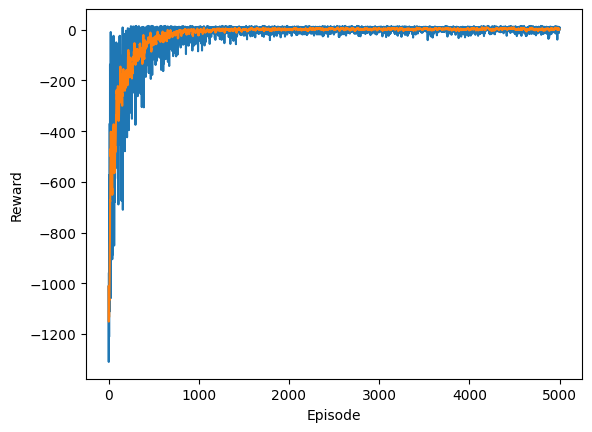

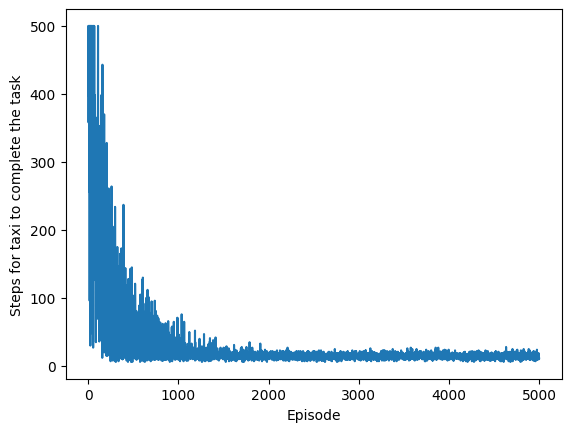

In [ ]:
avg_rewards_Q,Q= run_experiment_ql(gamma,alpha,epsilon,num_epsiodes,max_steps=max_steps,print_flag=True,plot_flag = True)

episode: 0, reward: -366, average_reward: -366.0,steps to goal 378
episode: 100, reward: 8, average_reward: 3.7,steps to goal 13
episode: 200, reward: 10, average_reward: 5.1,steps to goal 11
episode: 300, reward: 4, average_reward: 6.7,steps to goal 17
episode: 400, reward: 7, average_reward: 5.9,steps to goal 14
episode: 500, reward: 7, average_reward: 4.5,steps to goal 14
episode: 600, reward: 12, average_reward: 6.8,steps to goal 9
episode: 700, reward: 10, average_reward: 5.9,steps to goal 11
episode: 800, reward: 8, average_reward: 6.5,steps to goal 13
episode: 900, reward: 3, average_reward: 5.3,steps to goal 18
episode: 1000, reward: 5, average_reward: 5.2,steps to goal 16
episode: 1100, reward: 7, average_reward: 4.5,steps to goal 14
episode: 1200, reward: 6, average_reward: 7.4,steps to goal 15
episode: 1300, reward: 0, average_reward: 3.8,steps to goal 21
episode: 1400, reward: 0, average_reward: 3.5,steps to goal 21
episode: 1500, reward: 5, average_reward: 6.2,steps to goa

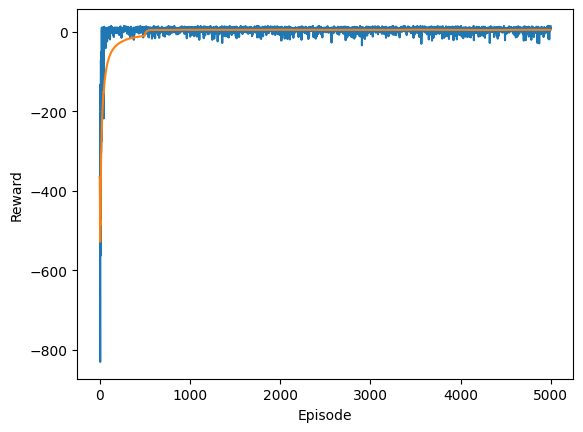

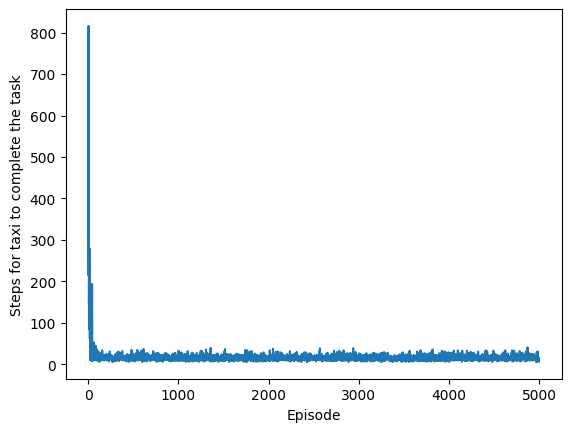

In [ ]:
avg_rewards_smdp,q_values_smdp,Q_hat_smdp = run_experiment_smdp(Option,gamma,alpha,epsilon,num_epsiodes,max_steps=None,print_flag=True,plot_flag = True)

episode: 0, reward: -470, average_reward: -470.0,steps to goal 482
episode: 100, reward: -10, average_reward: 3.2,steps to goal 31
episode: 200, reward: 6, average_reward: 0.8,steps to goal 15
episode: 300, reward: 4, average_reward: 3.8,steps to goal 17
episode: 400, reward: -9, average_reward: 0.9,steps to goal 30
episode: 500, reward: 3, average_reward: 5.4,steps to goal 18
episode: 600, reward: 8, average_reward: 4.9,steps to goal 13
episode: 700, reward: 4, average_reward: 5.3,steps to goal 17
episode: 800, reward: 12, average_reward: 6.3,steps to goal 9
episode: 900, reward: 7, average_reward: 5.1,steps to goal 14
episode: 1000, reward: 2, average_reward: 7.2,steps to goal 19
episode: 1100, reward: 4, average_reward: 4.5,steps to goal 17
episode: 1200, reward: 7, average_reward: 2.7,steps to goal 14
episode: 1300, reward: 3, average_reward: 3.8,steps to goal 18
episode: 1400, reward: 9, average_reward: 3.5,steps to goal 12
episode: 1500, reward: 5, average_reward: 3.5,steps to go

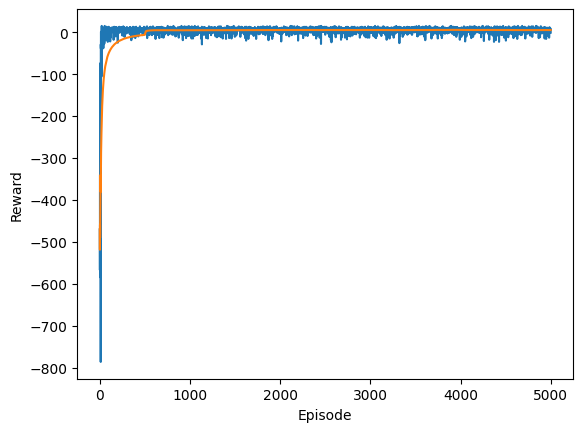

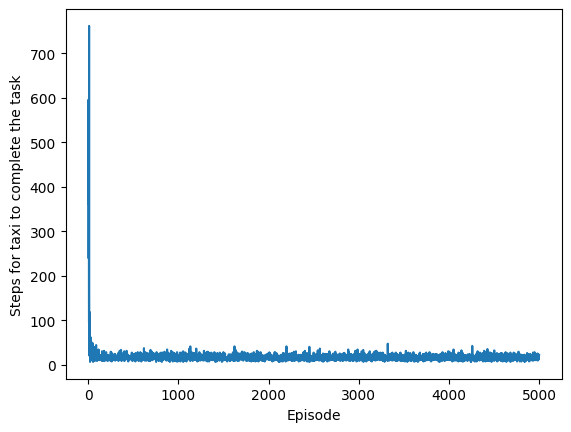

In [ ]:
avg_rewards_IO,q_values_IO,Q_hat_IO = run_experiment_IO(gamma,alpha,epsilon,num_epsiodes,max_steps=None,print_flag=True,plot_flag = True)

## Plotting Q-tables and Reward curves

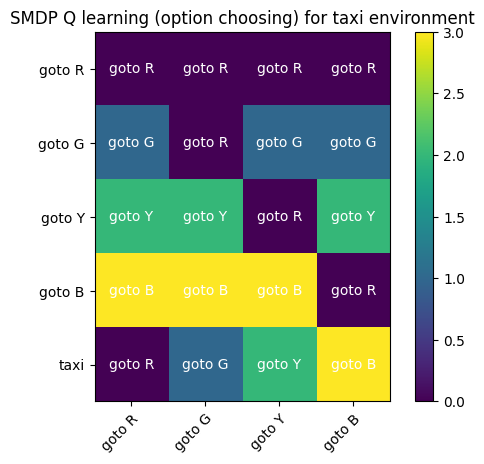

<Figure size 1000x1000 with 0 Axes>

In [ ]:
plot_option_choosing_Q_values(q_values_smdp,"SMDP Q learning (option choosing) for taxi environment")

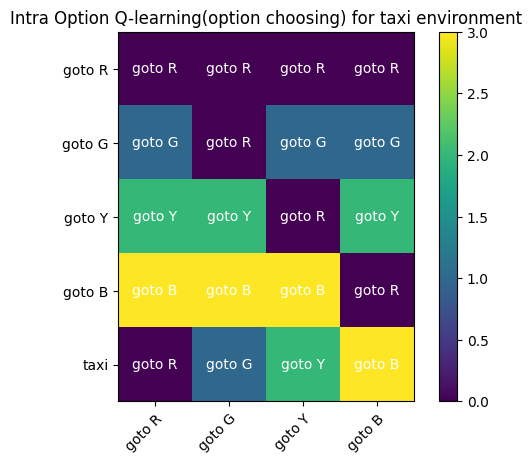

<Figure size 1000x1000 with 0 Axes>

In [ ]:
plot_option_choosing_Q_values(q_values_IO,"Intra Option Q-learning(option choosing) for taxi environment")

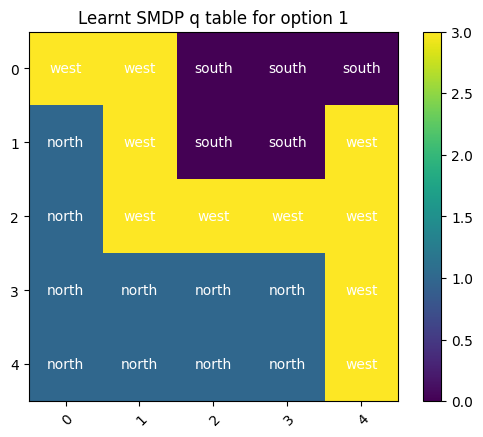

<Figure size 1000x1000 with 0 Axes>

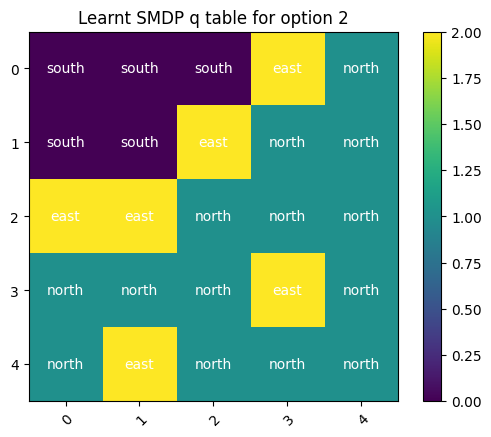

<Figure size 1000x1000 with 0 Axes>

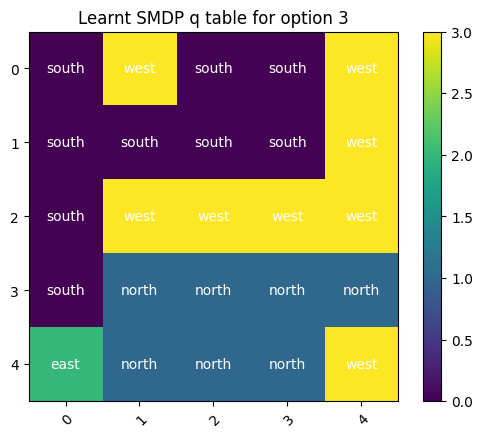

<Figure size 1000x1000 with 0 Axes>

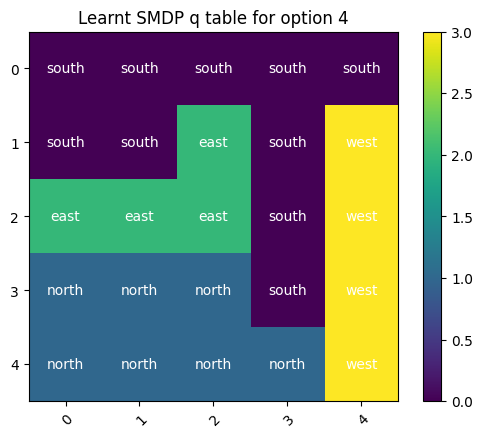

<Figure size 1000x1000 with 0 Axes>

In [ ]:
options = [0,1,2,3]
for i in range(len(options)):
  plot_taxi_policy_Q_values(Q_hat_smdp,i,f"Learnt SMDP q table for option {i+1}")

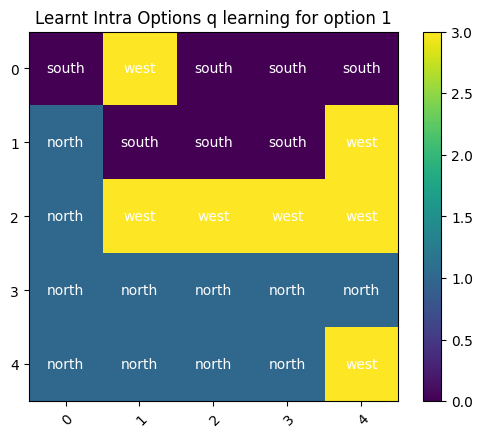

<Figure size 1000x1000 with 0 Axes>

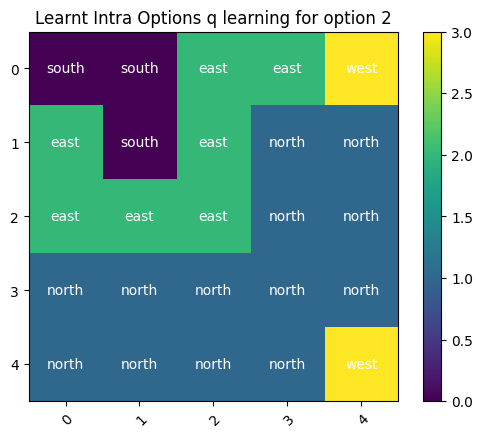

<Figure size 1000x1000 with 0 Axes>

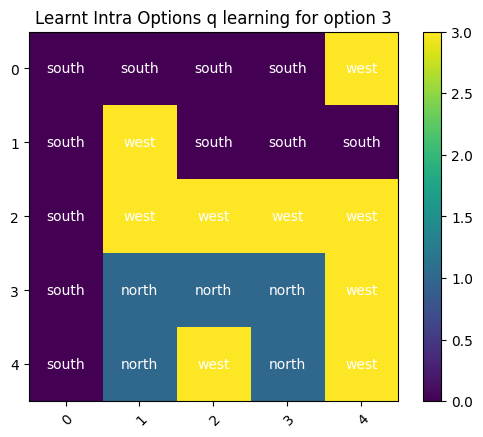

<Figure size 1000x1000 with 0 Axes>

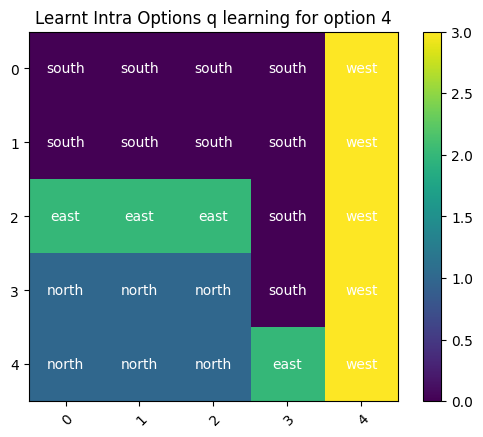

<Figure size 1000x1000 with 0 Axes>

In [ ]:
for i in range(len(options)):
  plot_taxi_policy_Q_values(Q_hat_IO,i,f"Learnt Intra Options q learning for option {i+1}")

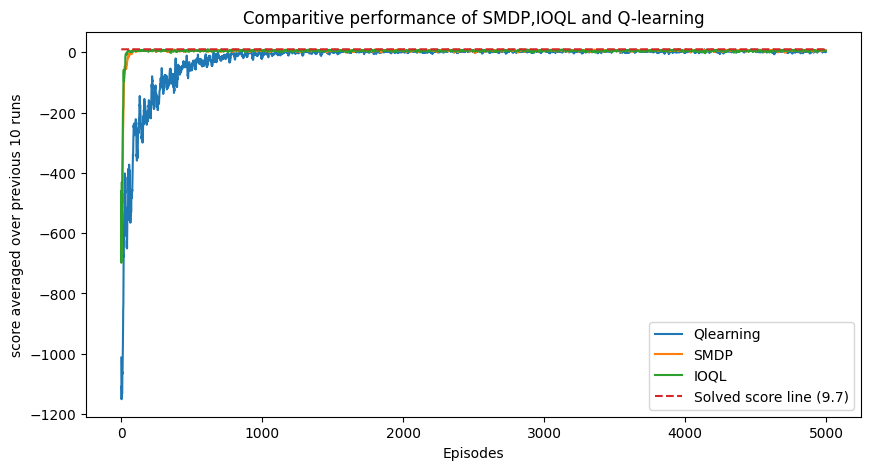

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(avg_rewards_Q ,label = 'Qlearning')
plt.plot(avg_rewards_smdp,label = 'SMDP')
plt.plot(avg_rewards_IO,label = 'IOQL')
plt.plot([9.7 for i in range(len(avg_rewards_Q))],'--',label = 'Solved score line (9.7)')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 10 runs')
plt.title('Comparitive performance of SMDP,IOQL and Q-learning')
plt.legend()

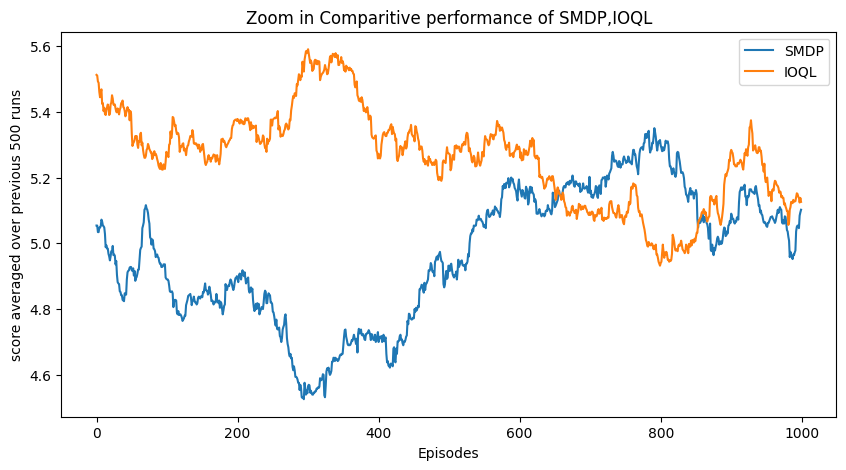

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(avg_rewards_smdp[-1000:],label = 'SMDP')
plt.plot(avg_rewards_IO[-1000:],label = 'IOQL')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 500 runs')
plt.title('Zoom in Comparitive performance of SMDP,IOQL')
plt.legend()

# Alternate Options

In [48]:
locations= {0:(0, 0), 1:(0, 4), 2:(4, 0), 3:(4, 3)}
def g_south(env,state):
  x,y,pas,drop = env.decode(state)
  optdone = False
  if x == 4:
    optdone = True
    if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = random.randint(2,3)
    else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = random.randint(2,3)
  else:
     if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = 0
     else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = 0
  return optact,optdone

def g_north(env,state):
  x,y,pas,drop = env.decode(state)
  optdone = False
  if x == 0:
    optdone = True
    if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = random.randint(2,3)
    else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = random.randint(2,3)
  else:
     if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = 1
     else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = 1
  return optact,optdone

def g_east(env,state):
  x,y,pas,drop = env.decode(state)
  optdone = False
  if y == 4:
    optdone = True
    if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = random.randint(0,1)
    else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = random.randint(0,1)
  else:
     if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = 2
     else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = 2
  return optact,optdone

def g_west(env,state):
  x,y,pas,drop = env.decode(state)
  optdone = False
  if y == 0:
    optdone = True
    if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = random.randint(0,1)
    else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = random.randint(0,1)
  else:
     if pas<4:
      if locations[pas] == (x,y):
        optact = 4
      else:
        optact = 3
     else:
      if locations[drop] == (x,y):
        optact = 5
      else:
        optact = 3
  return optact,optdone




options_dict = {0:"south",1:"north",2:"east",3:"west",4:'pickup',5:'drop',6:g_south,7:g_north,8:g_east,9:g_west}
options = list(options_dict.keys())

In [50]:
def execute_option(q,option,env,state):
  s_state = state
  optdone = False
  done = False
  k = 0
  ep_reward = 0
  reward_bar= 0
  while not optdone:
    k+=1
    optact,optdone = options_dict[option](env,state)
    next_state, reward,done,_,_ = env.step(optact)
    #print(option,list(env.decode(state)),optact,optdone)
    reward_bar = gamma*reward_bar + reward
    ep_reward+=reward
    if done:
      break
    state = next_state

  q[s_state][option] += alpha * (reward_bar + (gamma**k) * np.max(q[state]) - q[s_state][option])
  return q,ep_reward,state,done

In [ ]:
#### SMDP Q-Learning

gamma = 0.99
alpha=0.1
epsilon=0.1
q_values_SMDP = np.zeros((500,len(options)))
# Iterate over 1000 episodes
for i in range(1000):
    state,_ = env.reset()

    done = False
    ep_reward = 0
    # While episode is not over
    while not done:

        # Choose action
        action = egreedy_policy(q_values_SMDP, state, epsilon)
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done,_,_ = env.step(action)
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            state=next_state
            ep_reward+=reward

        if action>=6:
          option = action
          q_values_SMDP,opt_reward,state,done = execute_option(q_values_SMDP,option,env,state)
          ep_reward+=opt_reward


    print(f"Episode {i} =>{ep_reward}")